## Santander Product Recommendation 
### Kaggle Competition
### Brain Cleary  

In [1]:
from numpy import loadtxt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
color = sns.color_palette()
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.cross_validation import KFold, cross_val_score,StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
import csv
import datetime 
from operator import sub
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score
import datetime
from sklearn import preprocessing, ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
original_train = pd.read_csv("train_ver2.csv")
original_test = pd.read_csv("test_ver2.csv")

/Users/bcleary21/anaconda/envs/py27/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/bcleary21/anaconda/envs/py27/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


## Exploratory Data Visualization

In [3]:
df_train = original_train
df_test = original_test
print("Total rows Training: {0}".format(len(df_train)))
print("Total rows Test: {0}".format(len(df_test)))

Total rows Training: 13647309
Total rows Test: 929615


In [4]:
# Defining a variable for the categorical values 
cat_cols = ['ind_empleado','sexo','ind_nuevo','indrel','indrel_1mes',
            'tiprel_1mes','indresi','indext','conyuemp','indfall',
            'tipodom','ind_actividad_cliente','segmento',
            'pais_residencia','canal_entrada']

In [5]:
#  Selected the first 24 columns for features and remailning columns 
#  as product columns. Both of these columns will be used to predict Y, 
#  which will be the products that were added in the subsequent month. 

product_cols = list(df_train.iloc[:,24:]) 
target_cols = product_cols[:]
numeric_cols = ['age','antiguedad','renta','cod_prov']
features_scale = cat_cols+numeric_cols
features_scale2 = cat_cols+numeric_cols+target_cols

In [6]:
print("Descriptive Statistics on Training Data")
df_train[numeric_cols].describe()

Descriptive Statistics on Training Data


,renta,cod_prov
count,10852934.000000,13553718.000000
mean,134254.318238,26.571470
std,230620.238822,12.784017
min,1202.730000,1.000000
25%,68710.980000,15.000000
50%,101850.000000,28.000000
75%,155955.960000,35.000000
max,28894395.510000,52.000000


In [7]:
print("Descriptive Statistics on the Kaggle Prediction Data")
df_test[numeric_cols].describe()

Descriptive Statistics on the Kaggle Prediction Data


,age,antiguedad,cod_prov
count,929615.000000,929615.000000,925619.000000
mean,40.249821,77.728413,26.546150
std,17.185119,1797.824518,12.836614
min,2.000000,-999999.000000,1.000000
25%,25.000000,23.000000,15.000000
50%,39.000000,55.000000,28.000000
75%,51.000000,136.000000,35.000000
max,164.000000,257.000000,52.000000


In [8]:
# Function to gather the values of product columns--filling in 
# Null and "NA" so that I can compare which were added.  If I 
# do not do this, I can not reduce the dataset to only the customers 
# who added a product in a subsequent month. 

def getProduct(row):
    tlist = []
    for col in target_cols:
        if row[col].strip() in ['', 'NA']:
            target = 0
        else:
            target = int(float(row[col]))
        tlist.append(target)
    return tlist

# Function to gather values from the features column as is.  Null and 
# NA will be handled later to preserve information. 

def getCategorical(row, col):
    cat = row[col].strip()
    if cat not in ['','NA']:
        ind = cat
    else:
        ind = 'Unknown_Value'
    return ind

def getNumerical(row,col):
    numeric = row[col].strip()
    if numeric == 'NA' or numeric == '' or numeric == 'None':
        numeric = -1
    else:
        numeric = float64(numeric)
    return numeric
        
# This function allows me to create a data frame by only any given month
# to the subsequent month, allowing me model only rows which the users 
# added a product. The baseline will be trained on products added in June
# 2015 that were not present May 2015 to address seasonality.  I will check
# if any other months help or hurt this baseline. 

def processData(in_file_name, cust_dict):
    x_vars_list = []
    y_vars_list = []
    for row in csv.DictReader(in_file_name):
        if row['fecha_dato'] not in ['2015-05-28','2015-06-28', '2016-05-28', '2016-06-28']:
            continue

        cust_id = int(row['ncodpers'])
        if row['fecha_dato'] in ['2015-05-28','2016-05-28']:
            target_list = getProduct(row)
            cust_dict[cust_id] =  target_list[:]
            continue

        x_vars = []
        for col in cat_cols:
            x_vars.append(getCategorical(row, col))
        for col in numeric_cols:
            x_vars.append(getNumerical(row,col))

        if row['fecha_dato'] == '2016-06-28':
            prev_target_list = cust_dict.get(cust_id, [0]*24)
            x_vars_list.append(x_vars + prev_target_list)
        elif row['fecha_dato'] == '2015-06-28':
            prev_target_list = cust_dict.get(cust_id, [0]*24)
            target_list = getProduct(row)
            new_products = [max(x1 - x2,0) for (x1, x2) in zip(target_list, prev_target_list)]
            if sum(new_products) > 0:
                for ind, prod in enumerate(new_products):
                    if prod>0:
                        assert len(prev_target_list) == 24
                        x_vars_list.append(x_vars+prev_target_list)
                        y_vars_list.append(ind)

    return x_vars_list, y_vars_list, cust_dict

In [9]:
data_path = "/Users/bcleary21/Santander_project/"
train_file =  open(data_path + "train_ver2.csv")

# Select only customers with product in May 2015 that added one in June 2015 to 
# match seasonality with the actual Kaggle June predictions. Create a Y column based on the 
# products using numbers to represent each possible product 
x_vars_list, y_vars_list, cust_dict = processData(train_file, {})
train_X = np.array(x_vars_list)
train_y = np.array(y_vars_list)


In [10]:
# check if the all products are represented in the Y variable
index_Y = Counter(train_y).keys() # equals to list(set(words))
val_Y = Counter(train_y).values() # counts the elements' frequency

# check to see if all products have been added. 
Vals = ["Product {} has {:2} unique values".format(index_Y_,val_Y_) for val_Y_,index_Y_ in zip(val_Y,index_Y)]
Vals

['Product 2 has 9457 unique values',
 'Product 3 has  9 unique values',
 'Product 4 has 1934 unique values',
 'Product 5 has 55 unique values',
 'Product 6 has 349 unique values',
 'Product 7 has 222 unique values',
 'Product 8 has 154 unique values',
 'Product 9 has 503 unique values',
 'Product 10 has 33 unique values',
 'Product 11 has 1085 unique values',
 'Product 12 has 1219 unique values',
 'Product 13 has 246 unique values',
 'Product 14 has  4 unique values',
 'Product 15 has 21 unique values',
 'Product 16 has  8 unique values',
 'Product 17 has 2942 unique values',
 'Product 18 has 4755 unique values',
 'Product 19 has 159 unique values',
 'Product 20 has  3 unique values',
 'Product 21 has 5161 unique values',
 'Product 22 has 8229 unique values',
 'Product 23 has 9131 unique values']

In [11]:
# product 0 and 1 (python is zero-based) have not been added. Drop
# the first to products from my target_columns list
target_cols = product_cols[2:]

feature_cols = cat_cols+numeric_cols+product_cols
features_mod_TRAIN = pd.DataFrame(train_X, columns = feature_cols)
response_mod_TRAIN = pd.DataFrame(train_y, columns = ['Y_vars'])

# features_mod_TRAIN.iloc[:,2:20].head(100)
del x_vars_list, y_vars_list
train_file.close()
print(train_X.shape, train_y.shape)

for col in features_mod_TRAIN.columns[15:]:
    features_mod_TRAIN[col] = features_mod_TRAIN[col].astype('float')
    
df_May_June2015 = pd.concat([features_mod_TRAIN,response_mod_TRAIN], axis=1)

((45679, 43), (45679,))


In [12]:
test_file = open(data_path + "test_ver2.csv")   
x_vars_list, y_vars_list, cust_dict = processData(test_file, cust_dict)
test_X = np.array(x_vars_list)

In [13]:
df_June2016_PREDICT = pd.DataFrame(test_X, columns = feature_cols)

for cols in df_June2016_PREDICT.columns[15:]:
    df_June2016_PREDICT[cols] = df_June2016_PREDICT[cols].astype('float')

In [14]:
string_data = df_May_June2015.select_dtypes(include=["object"])
for col in string_data:
    print("Unique values for {0}:\n{1}\n".format(col,string_data[col].unique()))
del string_data

Unique values for ind_empleado:
['N' 'Unknown_Value' 'A' 'F' 'B']

Unique values for sexo:
['V' 'H' 'Unknown_Value']

Unique values for ind_nuevo:
['0' '1' 'Unknown_Value']

Unique values for indrel:
['1' '99' 'Unknown_Value']

Unique values for indrel_1mes:
['1' '1.0' 'Unknown_Value' '3.0']

Unique values for tiprel_1mes:
['I' 'A' 'Unknown_Value' 'P']

Unique values for indresi:
['S' 'N' 'Unknown_Value']

Unique values for indext:
['N' 'S' 'Unknown_Value']

Unique values for conyuemp:
['Unknown_Value' 'N']

Unique values for indfall:
['N' 'Unknown_Value' 'S']

Unique values for tipodom:
['1' 'Unknown_Value']

Unique values for ind_actividad_cliente:
['1' '0' 'Unknown_Value']

Unique values for segmento:
['03 - UNIVERSITARIO' '02 - PARTICULARES' '01 - TOP' 'Unknown_Value']

Unique values for pais_residencia:
['ES' 'AT' 'Unknown_Value' 'GB' 'FR' 'CH' 'DE' 'AR' 'VE' 'BR' 'IT' 'NL'
 'GA' 'MX' 'AD' 'US' 'PE' 'GR' 'PT' 'CL' 'PA' 'MA' 'BE' 'GQ' 'AU' 'SG' 'NG'
 'OM' 'PL' 'FI' 'CO' 'DO']

Uniq

In [15]:
string_data = df_June2016_PREDICT.select_dtypes(include=["object"])
for col in string_data:
    print("Unique values for {0}:\n{1}\n".format(col,string_data[col].unique()))
del string_data

Unique values for ind_empleado:
['F' 'N' 'A' 'B' 'S']

Unique values for sexo:
['V' 'H' 'Unknown_Value']

Unique values for ind_nuevo:
['0' '1']

Unique values for indrel:
['1' '99']

Unique values for indrel_1mes:
['1' '1.0' '3.0' '3' 'Unknown_Value']

Unique values for tiprel_1mes:
['A' 'I' 'P' 'Unknown_Value']

Unique values for indresi:
['S' 'N']

Unique values for indext:
['N' 'S']

Unique values for conyuemp:
['N' 'Unknown_Value' 'S']

Unique values for indfall:
['N' 'S']

Unique values for tipodom:
['1']

Unique values for ind_actividad_cliente:
['1' '0']

Unique values for segmento:
['01 - TOP' '02 - PARTICULARES' '03 - UNIVERSITARIO' 'Unknown_Value']

Unique values for pais_residencia:
['ES' 'CH' 'DE' 'GB' 'BE' 'DJ' 'IE' 'QA' 'US' 'VE' 'DO' 'SE' 'AR' 'CA' 'PL'
 'CN' 'CM' 'FR' 'AT' 'RO' 'LU' 'PT' 'CL' 'IT' 'MR' 'MX' 'SN' 'BR' 'CO' 'PE'
 'RU' 'LT' 'EE' 'MA' 'HN' 'BG' 'NO' 'GT' 'UA' 'NL' 'GA' 'IL' 'JP' 'EC' 'IN'
 'DZ' 'ET' 'SA' 'HU' 'JM' 'CI' 'CU' 'BO' 'TG' 'TN' 'NG' 'AU' 'GR' 'D

##### Recode categorical feature duplicates 

In [16]:
# Generic function to replace duplicates
def coding(col, codeDict):
  colCoded = pd.Series(col, copy=True)
  for key, value in codeDict.items():
    colCoded.replace(key, value, inplace=True)
  return colCoded

# Reclassify duplicate labels - Training Set
df_May_June2015['indrel_1mes'] = coding(df_May_June2015['indrel_1mes'], 
                                       {'1.0':'1','3.0':'3'})

# Reclassify duplicate labels - Kaggle Prediction Set
df_May_June2015['indrel_1mes'] = coding(df_May_June2015['indrel_1mes'], 
                                       {'1.0':'1','3.0':'3'})

###### Impute N/A values and recode numeric features:

In [17]:
def num_missing(x):
  return sum(x==-1)

print "TRAINING Missing values per Numeric column:"
print df_May_June2015[numeric_cols].apply(num_missing, axis=0)

TRAINING Missing values per Numeric column:
age              8
antiguedad       8
renta         6193
cod_prov       106
dtype: int64


In [18]:
def num_missing(x):
  return sum(x == -1)

print "Testing Missing values per Numeric column:"
print df_June2016_PREDICT[numeric_cols].apply(num_missing, axis=0)

Testing Missing values per Numeric column:
age                0
antiguedad         0
renta         227965
cod_prov        3996
dtype: int64


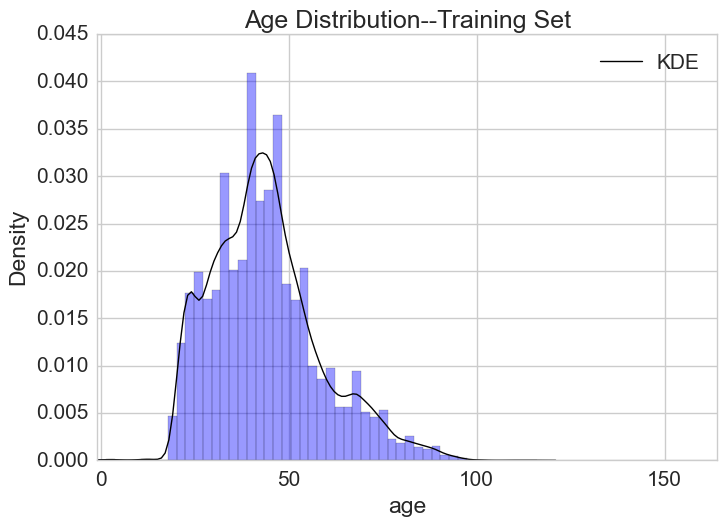

In [19]:
Age_Max_Train = df_June2016_PREDICT.age.max()

with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_May_June2015["age"],
                 bins=None,
                 kde_kws={"color": "black", "lw": 1, "label": "KDE"},
                 color="blue")
    sns.plt.title("Age Distribution--Training Set")
    plt.ylabel("Density")
    plt.xlim((-1, Age_Max_Train))

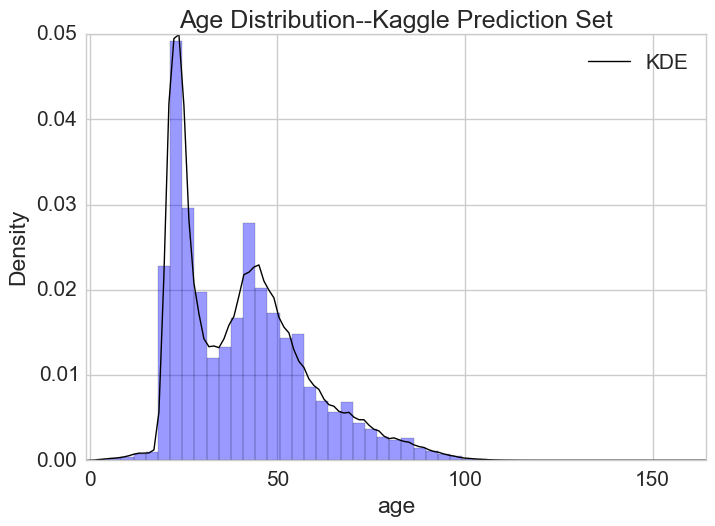

In [20]:
Age_Max_Predict = df_June2016_PREDICT.age.max()
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_June2016_PREDICT ["age"],
                 bins=None,
                 kde_kws={"color": "black", "lw": 1, "label": "KDE"},
                 color="blue")
    sns.plt.title("Age Distribution--Kaggle Prediction Set")
    plt.ylabel("Density")
    plt.xlim(-1, Age_Max_Predict)

###### Impute N/A values and recode Age of customer
Grouping 20, as 20 years old and over 90 as 90 to reduce extreme values. Customers unlikely to be adding many products in the tails. With 8 missing values in Training set, setting to 40---value most comming in Training set for customers that actually added products (younger people seem to be customers, but not ones that end up adding new products). 

In [21]:
# Training Data Set 
df_May_June2015.loc[df_May_June2015.age <= 20,"age"] = 20
df_May_June2015.loc[df_May_June2015.age >= 90,"age"] = 90
mean_age = 40
df_May_June2015.loc[df_May_June2015.age < 0,"age"] = mean_age


#Kaggle_Prediciton_Set
df_June2016_PREDICT.loc[df_June2016_PREDICT.age < 18,"age"] = 17
df_June2016_PREDICT.loc[df_June2016_PREDICT.age > 90,"age"] = 90
df_June2016_PREDICT["age"].fillna(df_June2016_PREDICT["age"].mean(),inplace=True)

###### Impute N/A values and recode Renta: Customer income
This seems important feature and many missing values in both the Training(6,193) and Kaggle prediction set(227,965). First lets look at the distribution to see if we want to recode any extremely high earners.

Maximum Income from Training set
22034738.76
Median Income from Training set
95560.77


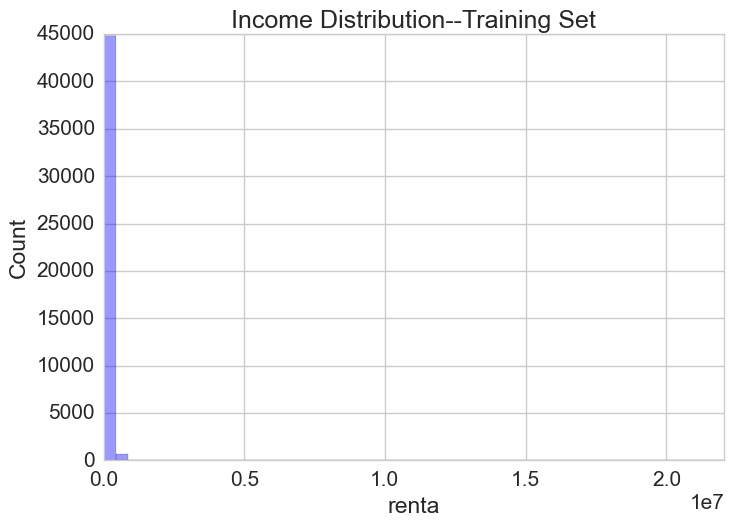

In [22]:
print "Maximum Income from Training set"
print df_May_June2015.renta.max()
print "Median Income from Training set"
median_Income = df_May_June2015.renta.median()
print median_Income
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_May_June2015["renta"],
                 bins=None,
                 kde = False,
                 #kde_kws={"color": "black", "lw": 1, "label": "KDE"},
                 color="blue")
    sns.plt.title("Income Distribution--Training Set")
    plt.ylabel("Count")
    plt.xlim((-1,df_May_June2015.renta.max()))

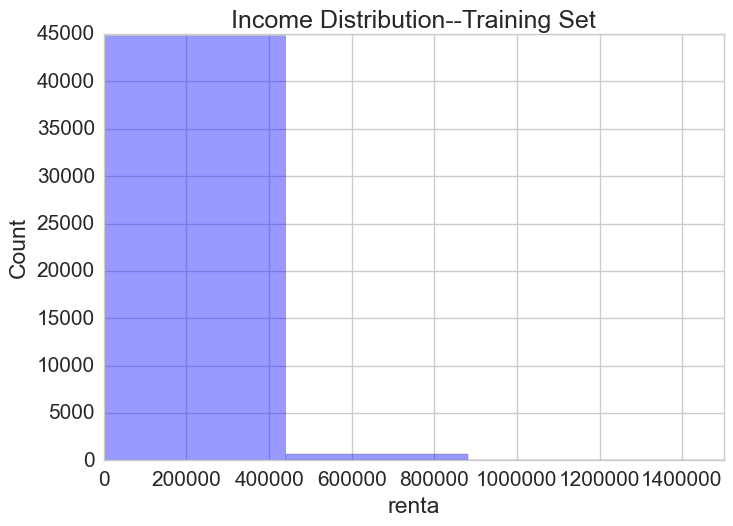

In [23]:
# A closer look at only people making less than $1.5M
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_May_June2015["renta"],
                 bins=None,
                 kde = False,
                 #kde_kws={"color": "black", "lw": 1, "label": "KDE"},
                 color="blue")
    sns.plt.title("Income Distribution--Training Set")
    plt.ylabel("Count")
    plt.xlim((-1,1500000))

In [24]:
# Training Data Set 
#code highest earners to $1.5M
df_May_June2015.loc[df_May_June2015.renta >= 1500000,"renta"] = 1500000
#Code missing values (-1) as median income
df_May_June2015.loc[df_May_June2015.renta < 0,"renta"] = median_Income

#Kaggle_Prediciton_Set
df_June2016_PREDICT.loc[df_June2016_PREDICT.renta >= 1500000,"renta"] = 1500000
#Code missing values (-1) as median income
df_June2016_PREDICT.loc[df_June2016_PREDICT.renta < 0,"renta"] = median_Income

###### Impute N/A values and recode Cod_prov: Sales Channel 
Replace the null values in Sales channel with the mode from the 
Training set

In [25]:
print "Recode missing values to the most frequent Sales Channel:"
mode_cod_prov = df_May_June2015.cod_prov.mode()[0]
print mode_cod_prov
# Training Data Set
df_May_June2015.loc[df_May_June2015.cod_prov <0,"cod_prov"]= mode_cod_prov
# Kaggle Data Set
df_June2016_PREDICT.loc[df_June2016_PREDICT.cod_prov<0,"cod_prov"]=mode_cod_prov

Recode missing values to the most frequent Sales Channel:
28.0


###### Impute N/A values and recode Antiquedad:  (Seniority)
Only 8 people are Null for seniority in the Training Set. Small number and 
will give them the least seniorty(zero)rather than remove them. 

In [26]:
# Training Data Set
df_May_June2015.loc[df_May_June2015.antiguedad <0,"antiguedad"]= mode_cod_prov
# Kaggle Data Set
df_June2016_PREDICT.loc[df_June2016_PREDICT.antiguedad<0,"antiguedad"]=mode_cod_prov

##### One-Hot Encoding: Dummy Variables 

In [27]:
def preprocess_features(X):
    ''' Preprocesses the data and converts non-numeric binary variables 
    intobinary (0/1) variables. Then, converts categorical 
    variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'tiprel_lmes' => 'tiprel_lmes_I',tiprel_lmes_A','tiprel_lmes_P'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [28]:
# Subset Features for predictions
X = df_May_June2015.iloc[:,:-1]
# Subset Y variable for predictions as array
Y = np.ravel(df_May_June2015.Y_vars)
X_test = df_June2016_PREDICT
print  X.shape
print Y.shape
print X_test.shape

(45679, 43)
(45679,)
(929615, 43)


In [29]:
df_Train_features = preprocess_features(X)
df_Predict_features = preprocess_features(X_test)
print "Processed feature columns ({} total features):".format(len(df_Train_features.columns))
print "Processed feature columns ({} total features):".format(len(df_Predict_features.columns))

Processed feature columns (219 total features):
Processed feature columns (346 total features):


In [30]:
Training_backup=df_Train_features
Predict =df_Predict_features

In [31]:
# Re-Index feature columns Alphabetically:
Train_sort = df_Train_features.reindex(columns=sorted(df_Train_features.columns))

In [32]:
Predict_sort = df_Predict_features.reindex(columns=sorted(df_Predict_features.columns))

In [33]:
# determine class labels in Predict data set that are not in Train
col_train_add = set(Predict_sort.columns) - set(Train_sort.columns)
print len(col_train_add)
# determine class labels in Train data set that are not in Predict
col_predict_add = set(Train_sort.columns) - set(Predict_sort.columns)
print len(col_predict_add)

136
9


In [34]:
#Add the column header and fill in values with zero so that the 
#dataframes are identical. 
for col in col_train_add:
    Train_sort[col] = 0
for col in col_predict_add:
    Predict_sort[col]=0
    
# verify that the columns are the same for both data sets
col_train_add = set(Predict_sort.columns) - set(Train_sort.columns)
print len(col_train_add)
# verify that the columns are the same for both data sets
col_predict_add = set(Train_sort.columns) - set(Predict_sort.columns)
print len(col_predict_add)

0
0


In [35]:
# Re-Index feature columns Alphabetically:
Train_sort = Train_sort.reindex(columns=sorted(Train_sort.columns))
Predict_sort= Predict_sort.reindex(columns=sorted(Predict_sort))

# Saving files to computer for ease of use 
#Data from May with June's product
response_mod_TRAIN = pd.DataFrame(Y, columns = ['Y'])
# merge Y onto Train_sort
train_sort2 = pd.concat([Train_sort,response_mod_TRAIN], axis=1)

In [36]:
df2_May_June2015 = train_sort2
df2_June2016_PREDICT = Predict_sort

# Subset Features for predictions
X = df2_May_June2015.iloc[:,:-1]
# Subset Y variable for predictions as array
Y = np.ravel(df2_May_June2015.Y)
X_test = df2_June2016_PREDICT

# check the shapes match after all the pre-processing and manipulation
print Y.shape
print X.shape
print X_test.shape

(45679,)
(45679, 355)
(929615, 355)


##### Scaling Features: Numeric Values 

In [37]:
features_scale =['age','antiguedad','renta','cod_prov']
# Initialize Standard Scaler to bring numeric values to same scale. 
std = StandardScaler()

X[features_scale] = std.fit_transform(X[features_scale])
X_test[features_scale] = std.fit_transform(X_test[features_scale])


#### Feature Selection/Extraction: Random Forrest

In [38]:
feat_labels_Train = X.columns[:]

# initialize Random Forrest Classifer 
forest = RandomForestClassifier(n_estimators=500, random_state=43,
                               n_jobs = -1)

forest.fit(X,Y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices  = indices[:25]

In [39]:
sum_x = np.sum(importances[indices])
print 'Total percent contribution of the top {} features is {:.2%}:'.format(25,(sum_x))

for f in range(len(indices)):
    print ("%2d %-*s %f" % (f,30,feat_labels_Train[indices[f]],importances[indices[f]]))

Total percent contribution of the top 25 features is 89.59%:
 0 age                            0.141702
 1 renta                          0.138927
 2 antiguedad                     0.134327
 3 cod_prov                       0.089250
 4 ind_cco_fin_ult1               0.074819
 5 ind_recibo_ult1                0.061477
 6 ind_cno_fin_ult1               0.042871
 7 ind_nom_pens_ult1              0.027689
 8 ind_nomina_ult1                0.023757
 9 ind_tjcr_fin_ult1              0.018078
10 ind_ecue_fin_ult1              0.014511
11 ind_reca_fin_ult1              0.014011
12 ind_ctop_fin_ult1              0.010708
13 canal_entrada_KFC              0.010698
14 canal_entrada_KAT              0.010690
15 ind_dela_fin_ult1              0.009747
16 ind_ctpp_fin_ult1              0.009612
17 sexo_V                         0.009390
18 sexo_H                         0.009371
19 segmento_02 - PARTICULARES     0.008124
20 ind_ctma_fin_ult1              0.008031
21 segmento_01 - TOP              0.

In [40]:
X = pd.DataFrame(X.iloc[:,indices ])
X.head()

,age,renta,antiguedad,cod_prov,ind_cco_fin_ult1,ind_recibo_ult1,ind_cno_fin_ult1,ind_nom_pens_ult1,ind_nomina_ult1,ind_tjcr_fin_ult1,...,ind_dela_fin_ult1,ind_ctpp_fin_ult1,sexo_V,sexo_H,segmento_02 - PARTICULARES,ind_ctma_fin_ult1,segmento_01 - TOP,ind_valo_fin_ult1,ind_nuevo_1,ind_nuevo_0
0,-1.084954,0.516000,-0.692672,0.089283,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,-1.084954,0.516000,-0.692672,0.089283,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.461941,-0.218546,-0.692672,0.089283,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
3,-0.461941,-0.218546,-0.692672,0.089283,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
4,-0.254271,-0.344954,-0.692672,0.089283,1,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1


In [41]:
X_test = pd.DataFrame(X_test.iloc[:,indices ])
X_test.head()

,age,renta,antiguedad,cod_prov,ind_cco_fin_ult1,ind_recibo_ult1,ind_cno_fin_ult1,ind_nom_pens_ult1,ind_nomina_ult1,ind_tjcr_fin_ult1,...,ind_dela_fin_ult1,ind_ctpp_fin_ult1,sexo_V,sexo_H,segmento_02 - PARTICULARES,ind_ctma_fin_ult1,segmento_01 - TOP,ind_valo_fin_ult1,ind_nuevo_1,ind_nuevo_0
0,0.927359,2.045076,2.603210,0.113011,1,0,0,0,0,1,...,0,1,1,0,0,0,1,1,0,1
1,-0.249811,-0.266993,-0.698311,-1.838689,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
2,-1.073831,-0.266993,-0.698311,-0.901873,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,-1.073831,0.262902,-0.698311,-1.448349,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,-1.073831,-0.153427,-0.698311,-1.526417,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [42]:
# get list of products to make predictions (only the 22 that were actually
# added in June 2015)

target_cols = np.array(['ind_cco_fin_ult1', 
    'ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1', 
    'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1',
    'ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1', 
    'ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1', 
    'ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1', 
    'ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1', 
    'ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1'])

In [43]:
# Benchmark model

# Creating Gaussian NB object for my algorithm
clf_GNB = GaussianNB()  

# fit the model on the training data
model_GNB = clf_GNB.fit(X,Y)

# Predict probabilities of each class label so that I can 
# later rank order them and choose the top 7 to submit to Kaggle.
preds = model_GNB.predict_proba(X_test)

# sort prediction with argument sort (i.e. the product)
preds = np.argsort(preds, axis=1)
# choose the 7 most likely product to be added
preds = np.fliplr(preds)[:,:7]
# merge predictions with customer IDs and save file
data_path = "/Users/bcleary21/Santander_project/"
test_id = np.array(pd.read_csv(data_path + "test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
final_preds = [" ".join(list(target_cols[pred])) for pred in preds]
out_df = pd.DataFrame({'ncodpers':test_id, 'added_products':final_preds})
out_df.to_csv('Baseline_Model_GNB.csv', index=False)

In [45]:
# Creating XGBoostClassifer object,enable probabalistic output
xgb_model = XGBClassifier(objective= 'multi:softprob',seed=43)

# Creating Logistic Regression classifier object,enable probabalistic output
Logistic_Reg_model = LogisticRegression(random_state=43, multi_class = 'ovr')


# initialilze Stratified KFold Object on dependent variable 
XGB_kfold = StratifiedKFold(Y, n_folds=3, random_state=43)  

# initialilze Stratified KFold Object on dependent variable 
Logistic_kfold = StratifiedKFold(Y, n_folds=3, random_state=7)  

# set param_grid to defaults for initial run
xgb_param_grid = {'learning_rate': [0.05, 0.075, 0.10], 'max_depth': [3,6,9],
                 'n_estimators': [100, 140, 175], 'colsample_bytree' : [0.75,1]}
                
Logistic_param_grid = {'C': [0.75, 1, 1.25], 'fit_intercept' : [True, False], 
                      'max_iter' : [100,150, 200], 'solver': ['newton-cg', 'lbfgs']}

#Using Log Loss scoring function and XGBoost
XGB_grid_search = GridSearchCV(xgb_model, xgb_param_grid,
                           scoring='log_loss',cv=XGB_kfold)
                
#Using Log Loss scoring function and SVC               
Logistic_grid_search = GridSearchCV(Logistic_Reg_model, Logistic_param_grid,
                           scoring='log_loss',cv=Logistic_kfold)

# XGB: fit the model on the training data
xgb_model_fit = XGB_grid_search.fit(X,Y)  

# Logistic: fit the model on the training data
Logistic_model_fit = Logistic_grid_search.fit(X,Y)
  
# Best Score from GridSearch
XGB_log_loss_GS = xgb_model_fit.grid_scores_                               
Logistic_log_loss_GS = Logistic_model_fit.grid_scores_
                   
# Select the best model from gridsearch to make predictions with
bst_xgb = xgb_model_fit.best_estimator_
bst_Logistic = Logistic_model_fit.best_estimator_

print "XGB Gridsearch results: {}".format(XGB_log_loss_GS)
print "Logistic Gridsearch : {}".format(Logistic_log_loss_GS)

XGB Gridsearch results: [mean: -1.66012, std: 0.03426, params: {'n_estimators': 100, 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'max_depth': 3}, mean: -1.68262, std: 0.02345, params: {'n_estimators': 140, 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'max_depth': 3}, mean: -1.71358, std: 0.04461, params: {'n_estimators': 175, 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'max_depth': 3}, mean: -1.84160, std: 0.12508, params: {'n_estimators': 100, 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'max_depth': 6}, mean: -1.88994, std: 0.17119, params: {'n_estimators': 140, 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'max_depth': 6}, mean: -1.93564, std: 0.20058, params: {'n_estimators': 175, 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'max_depth': 6}, mean: -1.94057, std: 0.17438, params: {'n_estimators': 100, 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'max_depth': 9}, mean: -1.99592, std: 0.20807, params: {'n_estimators': 140, 'learning_rate': 0.05, 'colsample

In [46]:
# Predict probabilities of each class label so that I can 
# later rank order them and choose the top 7 to submit to Kaggle.
print ("Making probability predictions for class labels")
XGB_preds = bst_xgb.predict_proba(X_test)
Logistic_preds = bst_Logistic.predict_proba(X_test)

print ("Selecting the top 7 products")
XGB_preds = np.argsort(XGB_preds, axis=1)
Logistic_preds = np.argsort(Logistic_preds, axis=1)   

# Choose the 7 most likely product to be added
XGB_preds = np.fliplr(XGB_preds)[:,:7]
Logistic_preds = np.fliplr(Logistic_preds)[:,:7]  

Making probability predictions for class labels
Selecting the top 7 products


In [47]:
# merge predictions with customer IDs and save file
data_path = "/Users/bcleary21/Santander_project/"
test_id = np.array(pd.read_csv(data_path + "test_ver2.csv", 
                               usecols=['ncodpers'])['ncodpers'])
                
# join customer ID (ncodpers) from prediction set with predictions
XGB_final_preds = [" ".join(list(target_cols[XGB_pred])) for XGB_pred in XGB_preds]
Logistic_final_preds = [" ".join(list(target_cols[Logistic_Pred])) for Logistic_Pred in Logistic_preds]                

In [48]:
# create and save data frame with Customer ID and predictions
XGB_out_df = pd.DataFrame({'ncodpers':test_id, 
                           'added_products':XGB_final_preds})

Logistic_out_df = pd.DataFrame({'ncodpers':test_id, 
                          'added_products':Logistic_final_preds}) 

print ("Saving predictions the top 7 products")     

XGB_out_df.to_csv('XGB_150.csv', index=False)

Logistic_out_df.to_csv('Logistic_defaults_GridSearch2.csv', index=False)

print len(XGB_out_df)
print len(Logistic_out_df)

bst_Logistic

Saving predictions the top 7 products
929615
929615


LogisticRegression(C=1.25, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=43, solver='lbfgs', tol=0.0001,
          verbose=0)

In [49]:
bst_xgb

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='multi:softprob', seed=43, silent=True,
       subsample=1)

** Table I: Scoring Results During Grid Search**  

|  Agorithim  | Log-Loss  | MAP@7 |
| :----------: | :-------------: | :-------------: | 
|Naive Bayes Benchmark |   N/A      |   0.0102542    |
|XGBoost Default hyper parameters(25 top features)| -1.64076  | 0.0261723|
|Logistic Default hyper parameters| -1.52672      |   0.0262049    |
|XGBoost Grid Search {learning_rate: 0.07, Depth:6} |-1.93174 | 0.0261231|
|Logistic GridSearch {class_weight:'auto';'C':[.5,.75,1,1.25,1.5,2]|   -2.32759    |   0.0217395    |
|XGBoost Grid Search {n_estimators:175, learning_rate: 0.07, Depth:6|-2.02292|0.0261223|
|XGBoost Default hyper parameters (all features)| -1.70643  | 0.0262804|


** Table II: Benchmark vs. XGBoost Final**  

|  Agorithim  |  MAP@7 |
| :----------: | :-------------: | :-------------: | 
|Naive Bayes Benchmark |  0.0102542    |
|XGBoost Default hyper parameters (all features)| 0.0262804 |

### Visualization: Feature Importance from Training Set
With parsimony as a guide, I wanted to show the relative importance of the top 25 features from the feature extraction process.

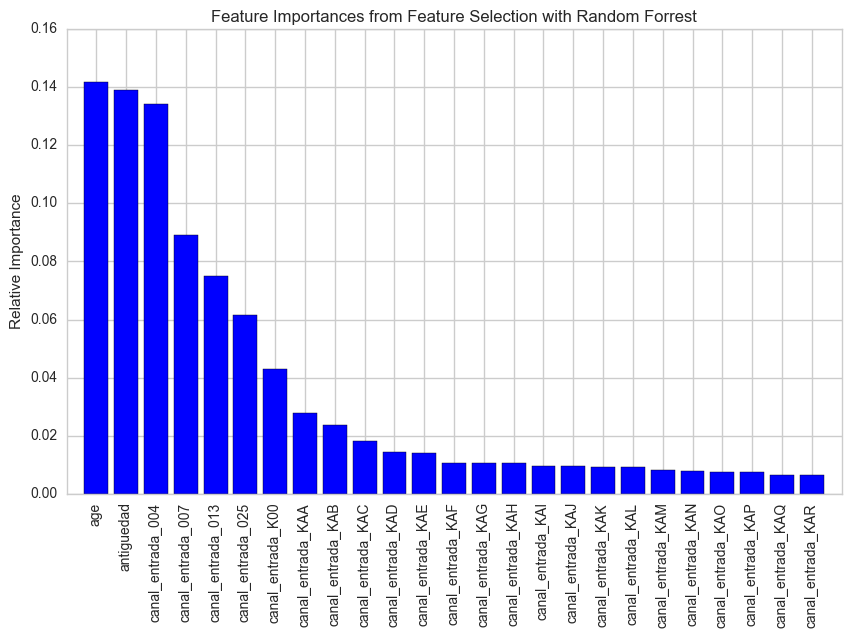

In [50]:
plt.title("Feature Importances from Feature Selection with Random Forrest")
plt.bar(range(X.shape[1]), importances[indices],
        color='blue', align='center')
plt.xticks(range(X.shape[1]), feat_labels_Train, rotation=90)
plt.xlim([-1,X.shape[1]])
plt.ylabel('Relative Importance')
plt.show()
